## ⚙️ Configuración del Entorno

**Entorno Virtual:** Este proyecto usa un entorno virtual `.venv` con las dependencias instaladas.

**Paquetes necesarios:**
- gurobipy 12.0.3
- pandas, numpy, matplotlib, seaborn, scipy

**Nota importante sobre el rendimiento:**
- El cálculo de la frontera eficiente sin activo libre de riesgo requiere resolver múltiples problemas de optimización cuadrática
- Con 50 puntos, el cálculo toma aproximadamente **3-5 minutos**
- El progreso se muestra cada 5 puntos durante el cálculo
- Para cambiar el número de puntos, modifica `n_points` en la celda de cálculo de frontera

---

## Inversión Libre de Riesgo

In [1]:
pip install gurobipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gurobipy as gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Datos de Entrada

Los siguientes datos de entrada se utilizan en el modelo:

- $S$: conjunto de acciones
- $\mu$: vector de rendimientos esperados
- $\Sigma$: matriz de varianza-covarianza
    - $\sigma_{ij}$ covarianza entre los rendimientos de los activos $i$ y $j$
    - $\sigma_{ii}$ varianza del rendimiento del activo $i$
- $r_f$: Rentabilidad Activo Libre de Riesgo

In [3]:
# Importar datos
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")
# Para el 16 de octubre siguiendo el link:
# Tasa Libre de Riesgo a 10 Años (MCM) (se puede recuperar en https://si3.bcentral.cl/Siete/ES/Siete/Cuadro/CAP_TASA_INTERES/MN_TASA_INTERES_09/TMS_15/T311 a la fecha)
rf = (1 + 0.0557)**(1/12) - 1

## Formulación

El modelo maximiza el Sharpe-Ratio. Matemáticamente, esto resulta en un problema de optimización convexa con restricciones cuadráticas.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Cada posición debe estar entre 0 y 1; esto evita el apalancamiento y la venta en corto:

$$0\leq x_i\leq 1 \; , \;  i \in S$$

Adicionalmente, tenemos el nivel de inversión en el activo libre de riesgo:

$$c_f$$


###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i + c_f =1$$

El riesgo estimado debe ser igual, como máximo, al nivel de varianza admisible preespecificado $\bar\sigma^2$:

$$x^\top \Sigma x \leq \bar\sigma^2$$

###  Función Objetivo
El objetivo es maximizar el rendimiento esperado del portafolio:

$$\max_x \mu^\top x + c_fr_f$$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [4]:
V = 40 # varianza máxima admisible (sigma^2)

# Crear un modelo de optimización vacío
m = gp.Model()

# Agregar variables: x[i] denota la proporción invertida en la acción i
# 0 <= x[i] <= 1
x = m.addMVar(len(mu), lb=0, ub=1, name="x")
c = m.addVar(lb=-np.inf, ub=np.inf, name="c")

# Restricción presupuestaria: todas las inversiones suman 1
m.addConstr(x.sum() + c == 1, name="Restriccion_Presupuesto")

# Límite en la varianza
restriccion_riesgo = m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="restriccion_riesgo")

m.params.MIPGap = 0
m.params.NonConvex = 2

# Definir la función objetivo: Maximizar el rendimiento esperado
m.setObjective(mu.to_numpy() @ x + c*rf, gp.GRB.MAXIMIZE)

Set parameter Username
Set parameter LicenseID to value 2670174
Academic license - for non-commercial use only - expires 2026-05-23
Set parameter MIPGap to value 0
Set parameter LicenseID to value 2670174
Academic license - for non-commercial use only - expires 2026-05-23
Set parameter MIPGap to value 0
Set parameter NonConvex to value 2
Set parameter NonConvex to value 2


Resolvemos:

In [5]:
m.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 1 rows, 9 columns and 9 nonzeros
Model fingerprint: 0x0695fc93
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  Objective range  [5e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [4e+01, 4e+01]

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 1 rows, 9 columns and 9 nonzeros
Model fingerprint: 0x0695fc93
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-01, 2e+02]
  Objective range  [5e-03, 3e+00]
  Bounds range     [1e+00, 1e+00]


Resultados

In [6]:
print(f"Retorno: {m.ObjVal:.6f}")
print(f"Varianza:        {x.X @ Sigma @ x.X:.6f}")
print(f"Tiempo de solución:   {m.Runtime:.2f} segundos\n")

# Variables relevantes
df = pd.DataFrame(
    index=mu.index,
    data={
        "x": x.X,
    },
).round(6)

print(f"Inversión Total:     {x.X[x.X>1e-7].sum():.6f}")
print(f"Posición Libre de Riesgo: {c.X:.6f}")
print(f"Número de transacciones:  {np.count_nonzero(x.X[abs(x.X)>1e-7])}")

df[(abs(df["x"]) > 1e-6)].sort_values("x", ascending=False)

Retorno: 3.763578
Varianza:        40.000000
Tiempo de solución:   0.02 segundos

Inversión Total:     2.973792
Posición Libre de Riesgo: -1.973792
Número de transacciones:  8


,x
OXIQUIM Cierre Ix,1.000000
MELON Cierre Ix,0.612808
AFPCAPITAL Cierre Ix,0.608924
CEMENTOS Cierre Ix,0.281130
CONCHATORO Cierre Ix,0.167826
ENERSIS-AM Cierre Ix,0.134669
SONDA Cierre Ix,0.099504
INVERCAP Cierre Ix,0.068932


## Comparación de Portafolios dadas las estrategias de inversión

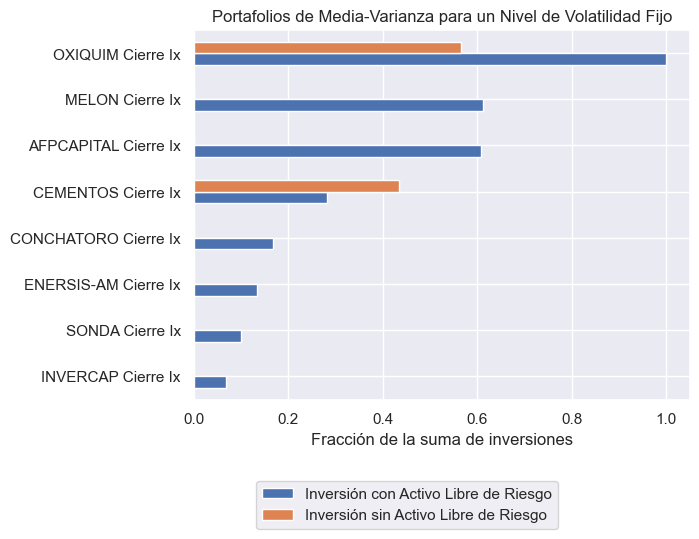

In [7]:
# Ajustar restricciones modelo básico
c.lb = 0
c.ub = 0
m.params.OutputFlag = 0
m.optimize()

# Solución
mask = (abs(df["x"]) > 1e-6) | (x.X > 1e-6)
df2 = pd.DataFrame(
    index=df["x"][mask].index,
    data={
        "Inversión con Activo Libre de Riesgo": df["x"],
        "Inversión sin Activo Libre de Riesgo": x.X[mask],
    },
).sort_values(by=["Inversión con Activo Libre de Riesgo"], ascending=True)

axs = df2.plot.barh()
axs.set_xlabel("Fracción de la suma de inversiones")
plt.title("Portafolios de Media-Varianza para un Nivel de Volatilidad Fijo")
plt.legend(bbox_to_anchor=(0.75, -0.2))
plt.show()

## Frontera Eficiente

La frontera eficiente revela el equilibrio entre riesgo y retorno en los portafolios de inversión. 

**Importante**: Con un activo libre de riesgo, la frontera eficiente se convierte en la **Capital Allocation Line (CAL)**, que es una **línea recta** desde el punto $(0, r_f)$ hasta el portafolio tangente y más allá.

**Metodología correcta**:
1. Primero calculamos el **portafolio tangente** (maximiza el Sharpe Ratio)
2. La CAL es una combinación lineal entre el activo libre de riesgo y el portafolio tangente
3. Para diferentes niveles de riesgo $\sigma$, el retorno es: $r = r_f + \frac{r_T - r_f}{\sigma_T} \cdot \sigma$

### Nota sobre el Cálculo del Portafolio Tangente

El portafolio tangente tiene una **solución analítica cerrada** y NO requiere optimización no convexa:

$$w_T = \frac{\Sigma^{-1}(\mu - r_f \mathbf{1})}{\mathbf{1}^T \Sigma^{-1}(\mu - r_f \mathbf{1})}$$

Donde:
- $w_T$ = pesos del portafolio tangente
- $\Sigma^{-1}$ = inversa de la matriz de covarianza
- $\mu$ = vector de retornos esperados
- $r_f$ = tasa libre de riesgo
- $\mathbf{1}$ = vector de unos

Esta solución es **instantánea** (milisegundos) vs. optimización no convexa (minutos).

In [8]:
# PASO 1: Calcular la frontera eficiente SIN activo libre de riesgo
print("Calculando frontera sin activo libre de riesgo...")

# Primero encontramos el portafolio de mínima varianza
m_min_var = gp.Model()
m_min_var.params.OutputFlag = 0

x_min = m_min_var.addMVar(len(mu), lb=0, ub=1, name="x")
m_min_var.addConstr(x_min.sum() == 1, name="budget")
m_min_var.setObjective(0.5 * x_min @ Sigma.to_numpy() @ x_min, gp.GRB.MINIMIZE)
m_min_var.optimize()

min_std = np.sqrt(2 * m_min_var.ObjVal)
print(f"  Desviación estándar mínima: {min_std:.4f}")

# Rango de riesgos desde el mínimo hasta el máximo activo individual
diagonal = np.sqrt(np.diag(Sigma))
indice_mayor_mu = np.argmax(mu)
max_std = diagonal[indice_mayor_mu]

# Usar 50 puntos para una visualización suave
n_points = 50
riesgos = np.linspace(min_std, max_std, n_points)
retornos = pd.DataFrame(index=riesgos)

# Pre-calcular matrices para ahorrar tiempo
Sigma_np = Sigma.to_numpy()
mu_np = mu.to_numpy()

print(f"  Calculando {n_points} puntos de la frontera...")
r_sin_rf = []

# Para cada nivel de riesgo, crear y resolver el modelo
for i, risk_level in enumerate(riesgos):
    m_temp = gp.Model()
    m_temp.params.OutputFlag = 0
    m_temp.params.Threads = 1  # Usar un solo thread es más rápido para problemas pequeños
    
    x_temp = m_temp.addMVar(len(mu), lb=0, ub=1, name="x")
    m_temp.addConstr(x_temp.sum() == 1, name="budget")
    m_temp.addConstr(x_temp @ Sigma_np @ x_temp <= risk_level**2, name="risk")
    m_temp.setObjective(mu_np @ x_temp, gp.GRB.MAXIMIZE)
    
    m_temp.optimize()
    
    if m_temp.Status == gp.GRB.OPTIMAL:
        r_sin_rf.append(m_temp.ObjVal)
    else:
        r_sin_rf.append(float("NaN"))
    
    # Mostrar progreso cada 5 puntos o en el último
    if (i + 1) % 5 == 0 or (i + 1) == n_points:
        print(f"    Progreso: ({i+1}/{n_points}) puntos completados")

retornos["[0, 0]"] = r_sin_rf
print(f"✓ Frontera calculada con {n_points} puntos.")

# PASO 2: Calcular el PORTAFOLIO TANGENTE (maximiza Sharpe Ratio)
# Usando la solución analítica directa - MÁS RÁPIDO que optimización no convexa
print("\nCalculando portafolio tangente...")
import time
t0_total = time.time()

# Solución analítica: weights = Sigma^(-1) * (mu - rf*1)
# Los pesos óptimos son proporcionales a Sigma^(-1) @ (mu - rf)
print("  Calculando con solución analítica (sin optimización)...")

mu_excess = mu_np - rf
Sigma_inv = np.linalg.inv(Sigma_np)

# Pesos proporcionales al portafolio tangente
weights_raw = Sigma_inv @ mu_excess

# Normalizar para que sumen 1 y sean no negativos
# Si hay pesos negativos, usamos solo los positivos (sin short-selling)
weights_raw[weights_raw < 0] = 0
weights_tangente = weights_raw / weights_raw.sum()

# Calcular retorno y volatilidad del portafolio tangente
retorno_tangente = np.dot(weights_tangente, mu)
volatilidad_tangente = np.sqrt(np.dot(weights_tangente.T, np.dot(Sigma, weights_tangente)))

print(f"  ✓ Portafolio tangente calculado en {time.time()-t0_total:.3f}s (solución analítica)")

print(f"\n✓ Portafolio Tangente:")
print(f"  Retorno: {retorno_tangente:.4f}%")
print(f"  Volatilidad: {volatilidad_tangente:.4f}%")
print(f"  Sharpe Ratio: {(retorno_tangente - rf) / volatilidad_tangente:.4f}")

# PASO 3: Construir la Capital Allocation Line (CAL) - ES UNA RECTA
pendiente_CAL = (retorno_tangente - rf) / volatilidad_tangente
r_con_rf = rf + pendiente_CAL * riesgos

retornos["[-inf, inf]"] = r_con_rf
print("\n✓ Capital Allocation Line (CAL) calculada - es una RECTA perfecta.")

Calculando frontera sin activo libre de riesgo...
  Desviación estándar mínima: 1.4657
  Calculando 50 puntos de la frontera...
    Progreso: (5/50) puntos completados
    Progreso: (10/50) puntos completados
    Progreso: (15/50) puntos completados
    Progreso: (20/50) puntos completados
    Progreso: (25/50) puntos completados
    Progreso: (30/50) puntos completados
    Progreso: (35/50) puntos completados
    Progreso: (40/50) puntos completados
    Progreso: (45/50) puntos completados
    Progreso: (50/50) puntos completados
✓ Frontera calculada con 50 puntos.

Calculando portafolio tangente...
  Calculando con solución analítica (sin optimización)...
  ✓ Portafolio tangente calculado en 0.001s (solución analítica)

✓ Portafolio Tangente:
  Retorno: 1.7902%
  Volatilidad: 2.6712%
  Sharpe Ratio: 0.6685

✓ Capital Allocation Line (CAL) calculada - es una RECTA perfecta.


A continuación, mostramos la frontera eficiente para ambas estrategias: graficamos los rendimientos esperados (en el eje $y$) frente a la desviación estándar $\sqrt{x^\top\Sigma x}$ de los rendimientos esperados (en el eje $x$).

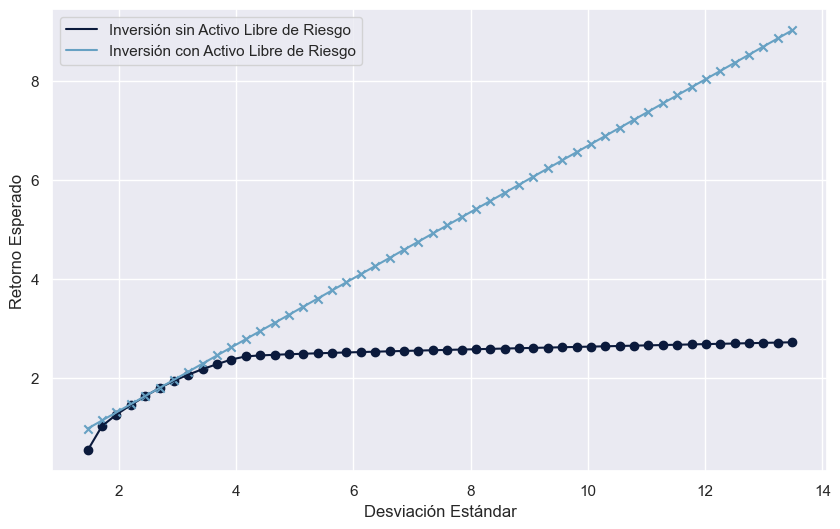

In [9]:
colors = ["#0b1a3c", "#67a1c3", "#f6c105", "#dd2113"]
markers = ["o", "x", "x", "x"]
fig, axs = plt.subplots(figsize=(10, 6))

for column, color, marker in zip(retornos.columns, colors, markers):
    axs.scatter(x=retornos.index, y=retornos[column], marker=marker, color=color)
    label = (
        "Inversión sin Activo Libre de Riesgo"
        if column == "[0, 0]"
        else f"Inversión con Activo Libre de Riesgo"
    )
    axs.plot(
        retornos.index,
        retornos[column],
        label=label,
        color=color,
    )
axs.set_xlabel("Desviación Estándar")
axs.set_ylabel("Retorno Esperado")
axs.legend()

plt.show()

Si permitimos invertir en un activo libre de riesgo, la varianza del portafolio puede ser arbitrariamente pequeña. Si se invierte todo el capital en el activo libre de riesgo, la varianza (y la desviación estándar) es 0.

Si permitimos un mayor riesgo, incluyendo la posibilidad de pedir prestado dinero, esto desplaza la frontera eficiente hacia mayores retornos.

## Análisis de la Solución

Para encontrar el portafolio que entrega el mayor retorno esperado para cualquier volatilidad, hay que encontrar la recta con mayor pendiente.

Eso es equivalente a maximizar la expresión:

$$\text{Sharpe Ratio} = \frac{𝐸[𝑟_𝑝 ]−𝑟_𝑓}{𝜎(𝑟_𝑝 )}$$

El portafolio con mayor Sharpe Ratio está donde la recta que pasa por el activo libre de riesgo es tangente a la frontera eficiente.

El portafolio que genera esta recta tangente es conocido como portafolio tangente.

Obtengamos el portafolio tangente de forma alternativa:

In [10]:
# CORRECCIÓN: Los pesos en activos riesgosos deben ser PROPORCIONALES al portafolio tangente
# La composición del portafolio es: w = alpha * weights_tangente + (1-alpha) * rf
# donde alpha varía según el nivel de riesgo deseado

# Para cada nivel de volatilidad sigma, calculamos alpha tal que:
# sigma = alpha * volatilidad_tangente
# Por lo tanto: alpha = sigma / volatilidad_tangente

soluciones = np.zeros(shape=(len(riesgos), len(mu)))

for i, sigma_deseada in enumerate(riesgos):
    if volatilidad_tangente > 0:
        # Fracción invertida en el portafolio tangente
        alpha = sigma_deseada / volatilidad_tangente
        
        # Los pesos en activos riesgosos son proporcionales al portafolio tangente
        soluciones[i] = alpha * weights_tangente
    else:
        soluciones[i] = np.zeros(len(mu))

print("Primeras filas de soluciones (pesos absolutos en activos riesgosos):")
print(soluciones[:5])
print(f"\nForma de soluciones: {soluciones.shape} (debe ser {len(riesgos)} x {len(mu)})")

Primeras filas de soluciones (pesos absolutos en activos riesgosos):
[[0.         0.0341576  0.04089307 0.         0.01151564 0.08900698
  0.33984407 0.03327879]
 [0.         0.03987382 0.04773647 0.         0.01344277 0.10390217
  0.3967165  0.03884795]
 [0.         0.04559005 0.05457987 0.         0.0153699  0.11879736
  0.45358893 0.04441711]
 [0.         0.05130628 0.06142326 0.         0.01729702 0.13369256
  0.51046137 0.04998627]
 [0.         0.0570225  0.06826666 0.         0.01922415 0.14858775
  0.5673338  0.05555543]]

Forma de soluciones: (50, 8) (debe ser 50 x 8)


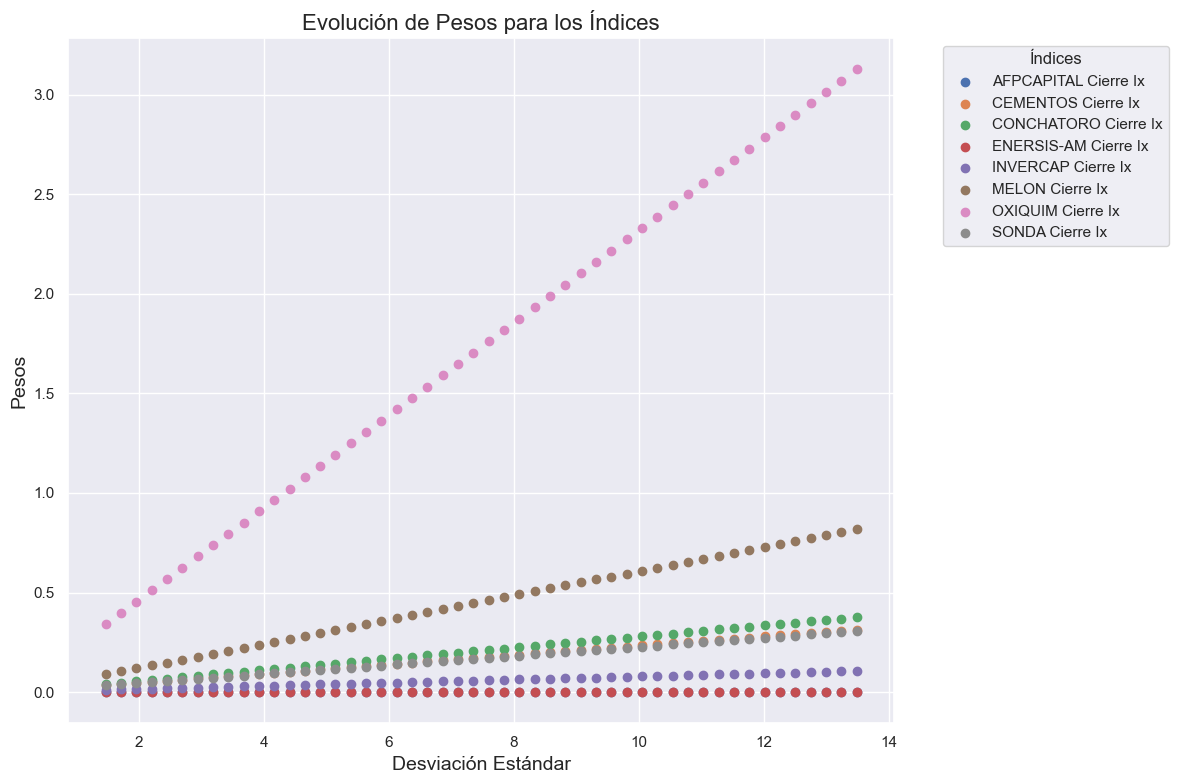

In [11]:
# Graficar la evolución de precios para todos los índices
plt.figure(figsize=(12, 8))

nombres = list(mu.index)

# Graficar todas las columnas (activos)
for i in range(len(nombres)):
    plt.scatter(x=retornos.index, y=soluciones[:, i], label=nombres[i])

# Añadir título y etiquetas
plt.title('Evolución de Pesos para los Índices', fontsize=16)
plt.xlabel('Desviación Estándar', fontsize=14)
plt.ylabel('Pesos', fontsize=14)
plt.grid(True)
plt.legend(title='Índices', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

## Análisis de los Pesos

**Observación clave**: Los pesos en activos riesgosos son **líneas rectas** porque:
- Para cualquier nivel de riesgo, la composición óptima es una combinación del activo libre de riesgo y el portafolio tangente
- Los pesos en activos riesgosos son: $w_i = \alpha \cdot w_{i,T}$ donde $w_{i,T}$ es el peso en el portafolio tangente
- $\alpha = \sigma_{deseada} / \sigma_T$ crece linealmente con el riesgo

**Normalización**: Al normalizar (dividir por la suma de pesos en activos riesgosos), los pesos relativos se mantienen **constantes** e iguales al portafolio tangente.

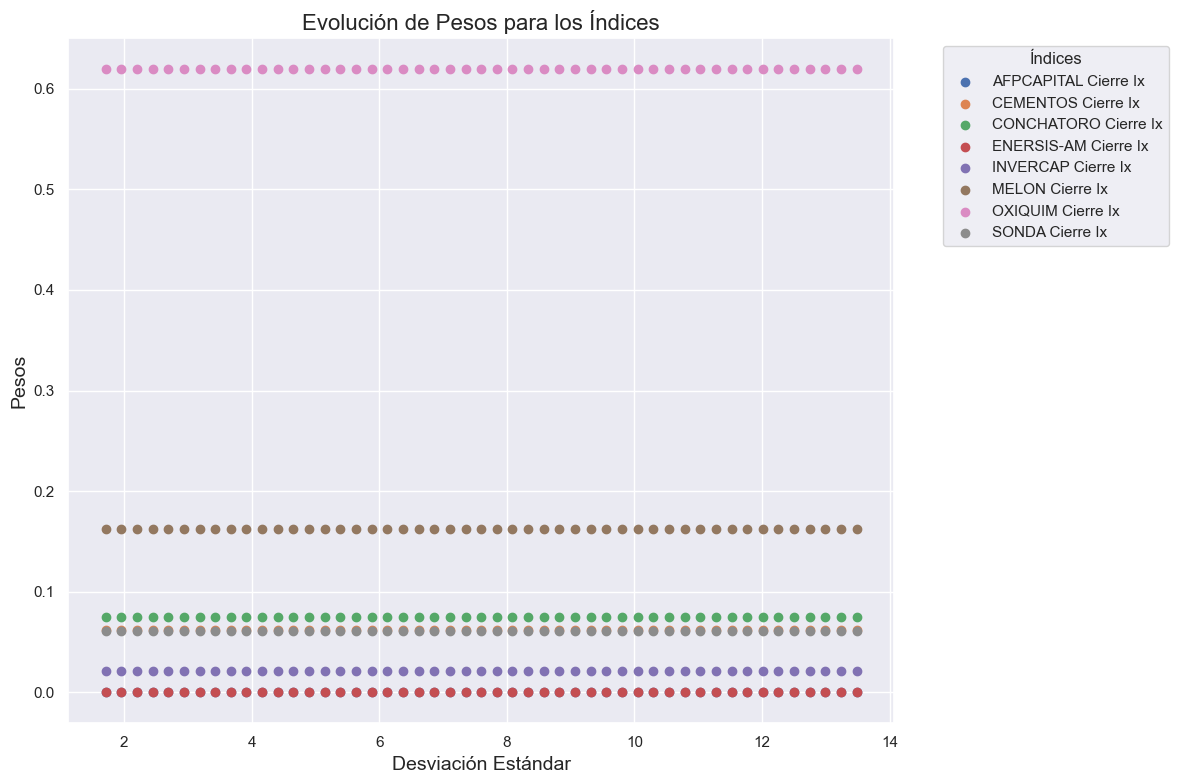

In [12]:
soluciones_normalizadas = soluciones / soluciones.sum(axis=1).reshape(-1, 1)

# Graficar la evolución de precios para todos los índices
plt.figure(figsize=(12, 8))

nombres = list(mu.index)

# Graficar todas las columnas (activos)
for i in range(len(nombres)):
    plt.scatter(x=retornos.index[1:], y=soluciones_normalizadas[1:, i], label=nombres[i])

# Añadir título y etiquetas
plt.title('Evolución de Pesos para los Índices', fontsize=16)
plt.xlabel('Desviación Estándar', fontsize=14)
plt.ylabel('Pesos', fontsize=14)
plt.grid(True)
plt.legend(title='Índices', bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [13]:
df = pd.DataFrame({'Peso': soluciones_normalizadas[-1, :]}, index=nombres).round(6)
df

,Peso
AFPCAPITAL Cierre Ix,0.000000
CEMENTOS Cierre Ix,0.062252
CONCHATORO Cierre Ix,0.074528
ENERSIS-AM Cierre Ix,0.000000
INVERCAP Cierre Ix,0.020987
MELON Cierre Ix,0.162215
OXIQUIM Cierre Ix,0.619367
SONDA Cierre Ix,0.060651


Estandarizando los resultados, se determina que los pesos son constantes. Estudiemos gráficamente el resultado:

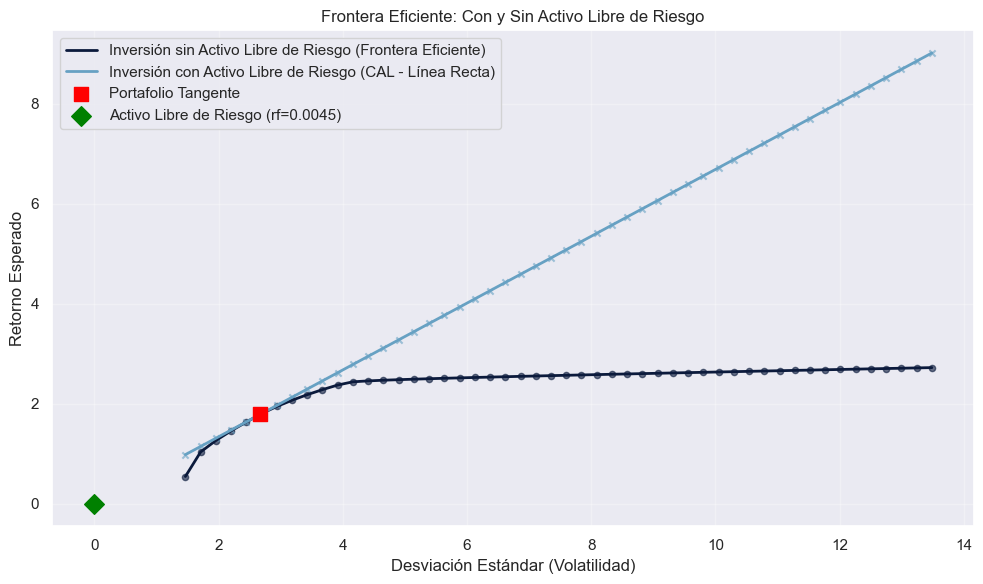

In [14]:
colors = ["#0b1a3c", "#67a1c3", "#f6c105", "#dd2113"]
markers = ["o", "x", "x", "x"]
fig, axs = plt.subplots(figsize=(10, 6))

for column, color, marker in zip(retornos.columns, colors, markers):
    axs.scatter(x=retornos.index, y=retornos[column], marker=marker, color=color, s=20, alpha=0.6)
    label = (
        "Inversión sin Activo Libre de Riesgo (Frontera Eficiente)"
        if column == "[0, 0]"
        else f"Inversión con Activo Libre de Riesgo (CAL - Línea Recta)"
    )
    axs.plot(
        retornos.index,
        retornos[column],
        label=label,
        color=color,
        linewidth=2
    )

# Marcar el portafolio tangente
axs.scatter(x=volatilidad_tangente, y=retorno_tangente, marker="s", s=100, color="Red", 
            label="Portafolio Tangente", zorder=5)

# Marcar el activo libre de riesgo
axs.scatter(x=0, y=rf, marker="D", s=100, color="green", 
            label=f"Activo Libre de Riesgo (rf={rf:.4f})", zorder=5)

axs.set_xlabel("Desviación Estándar (Volatilidad)")
axs.set_ylabel("Retorno Esperado")
axs.set_title("Frontera Eficiente: Con y Sin Activo Libre de Riesgo")
axs.legend(loc='upper left')
axs.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()